In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import datetime

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from scipy.stats import norm

import lightgbm as lgbm
import xgboost as xgb
sns.set()

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def lgbm_rmsle(y_true, y_pred):
    return ('rmsle',rmsle(y_true, y_pred),False)

def lgbm_rmse(y_true, y_pred):
    return ('rmse',rmse(y_true, y_pred),False)

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")
print(train.shape, test.shape, sample.shape)
display(train.head())
display(test.head())
display(sample.head())

(292150, 14) (119879, 13) (119879, 2)


,sampleid,timestamp,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location,PM
0,GiddBdhDWG,2013-03-01 00:00:00,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,location$1,4.0
1,ykjZlYdMfW,2013-03-01 00:00:00,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,location$2,3.0
2,CuiMubbpfk,2013-03-01 00:00:00,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,location$3,4.0
3,jvDAgMwveg,2013-03-01 00:00:00,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,location$4,9.0
4,UKIdubjtsW,2013-03-01 00:00:00,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,location$5,4.0


,sampleid,timestamp,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location
0,LYthQFByHI,2016-01-01 00:00:00,47.0,123.0,5300.0,13.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$1
1,DeOEAKFLzf,2016-01-01 00:00:00,12.0,101.0,2600.0,3.0,-3.8,1019.6,-9.6,0.0,NNW,1.2,location$2
2,ngkfVxOpDr,2016-01-01 00:00:00,22.0,76.0,3600.0,2.0,-3.8,1019.6,-9.6,0.0,NNW,1.2,location$3
3,NeKYkKNlNc,2016-01-01 00:00:00,31.0,98.0,3400.0,2.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$4
4,dYLujzbNVi,2016-01-01 00:00:00,54.0,118.0,5400.0,6.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$5


,sampleid,PM
0,LYthQFByHI,0.1
1,DeOEAKFLzf,0.1
2,ngkfVxOpDr,0.1
3,NeKYkKNlNc,0.1
4,dYLujzbNVi,0.1


In [3]:
id_column = 'sampleid'
target_column = 'PM'

# remvoing target from train
target = train[target_column]
train.drop(columns=target_column,inplace=True)

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(train.shape, test.shape)
display(train.head())
display(test.head())

(292150, 13) (119879, 13)


,sampleid,timestamp,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location
0,GiddBdhDWG,2013-03-01,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,location$1
1,ykjZlYdMfW,2013-03-01,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,location$2
2,CuiMubbpfk,2013-03-01,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,location$3
3,jvDAgMwveg,2013-03-01,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,NNW,5.7,location$4
4,UKIdubjtsW,2013-03-01,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,location$5


,sampleid,timestamp,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location
0,LYthQFByHI,2016-01-01,47.0,123.0,5300.0,13.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$1
1,DeOEAKFLzf,2016-01-01,12.0,101.0,2600.0,3.0,-3.8,1019.6,-9.6,0.0,NNW,1.2,location$2
2,ngkfVxOpDr,2016-01-01,22.0,76.0,3600.0,2.0,-3.8,1019.6,-9.6,0.0,NNW,1.2,location$3
3,NeKYkKNlNc,2016-01-01,31.0,98.0,3400.0,2.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$4
4,dYLujzbNVi,2016-01-01,54.0,118.0,5400.0,6.0,-2.5,1024.5,-8.2,0.0,NNE,1.1,location$5


count    292150.000000
mean         81.832125
std          80.167309
min           2.000000
25%          22.000000
50%          58.000000
75%         114.000000
max         844.000000
Name: PM, dtype: float64


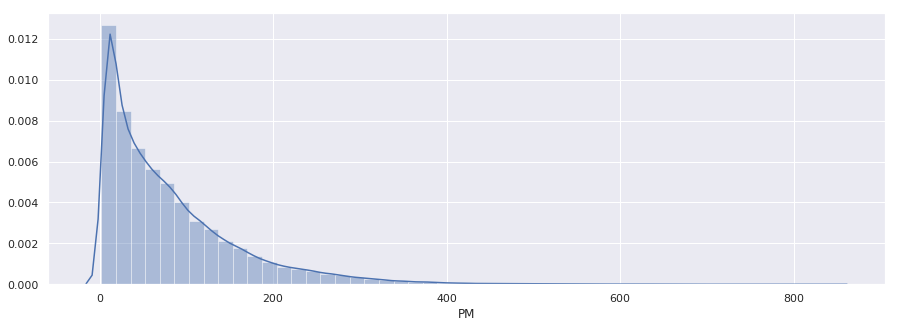

In [4]:
print(target.describe())
plt.figure(figsize=(15,5))
sns.distplot(target)
plt.show()

There are some outliers in the data. Like 844 seems to extreme.

In [5]:
# train time and test time
print("The time in train is",train['timestamp'].min(),"to",train['timestamp'].max())
print("The time in test is",test['timestamp'].min(),"to",test['timestamp'].max())

The time in train is 2013-03-01 00:00:00 to 2015-12-31 23:00:00
The time in test is 2016-01-01 00:00:00 to 2017-02-28 23:00:00


In [6]:
train.isnull().sum()

sampleid                 0
timestamp                0
sulphur dioxide       3077
nitrogen dioxide      5676
carborn monooxide    13978
ozone                 6414
temperature            179
pressure               180
dewpoint               184
rainfall               176
wind direction         625
wind speed             177
location                 0
dtype: int64

In [7]:
test.isnull().sum()

sampleid                0
timestamp               0
sulphur dioxide       621
nitrogen dioxide     1071
carborn monooxide    1184
ozone                1731
temperature           219
pressure              213
dewpoint              219
rainfall              214
wind direction       1172
wind speed            140
location                0
dtype: int64

In [8]:
l = sorted(list(set(train['location']).union(set(test['location']))))
location_encoder = dict(zip(l,range(len(l))))
location_encoder

{'location$1': 0,
 'location$10': 1,
 'location$11': 2,
 'location$12': 3,
 'location$2': 4,
 'location$3': 5,
 'location$4': 6,
 'location$5': 7,
 'location$6': 8,
 'location$7': 9,
 'location$8': 10,
 'location$9': 11}

In [9]:
l = sorted(list(set(train['wind direction'].dropna()).union(set(test['wind direction'].dropna()))))
wind_direction_encoder = dict(zip(l,range(len(l))))
wind_direction_encoder

{'E': 0,
 'ENE': 1,
 'ESE': 2,
 'N': 3,
 'NE': 4,
 'NNE': 5,
 'NNW': 6,
 'NW': 7,
 'S': 8,
 'SE': 9,
 'SSE': 10,
 'SSW': 11,
 'SW': 12,
 'W': 13,
 'WNW': 14,
 'WSW': 15}

In [10]:
def preprocess(df):
    df['wind direction'] = df['wind direction'].map(wind_direction_encoder)
    df['location'] = df['location'].map(location_encoder)
    
    # time related variables
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['weekday'] = df['timestamp'].dt.dayofweek
    df['weekofmonth'] = (df['timestamp'].dt.day/7).astype(int) + 1
    
    # dropping timestamp
    df = df.drop(columns=['timestamp'])
    return df

train = preprocess(train)
test = preprocess(test)

print(train.shape, test.shape)
display(train.head())
display(test.head())

(292150, 16) (119879, 16)


,sampleid,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location,month,hour,weekday,weekofmonth
0,GiddBdhDWG,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,6.0,4.4,0,3,0,4,1
1,ykjZlYdMfW,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.0,0.5,4,3,0,4,1
2,CuiMubbpfk,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,0.0,0.5,5,3,0,4,1
3,jvDAgMwveg,3.0,17.0,300.0,89.0,-0.5,1024.5,-21.4,0.0,6.0,5.7,6,3,0,4,1
4,UKIdubjtsW,14.0,20.0,300.0,69.0,-0.7,1023.0,-18.8,0.0,6.0,4.4,7,3,0,4,1


,sampleid,sulphur dioxide,nitrogen dioxide,carborn monooxide,ozone,temperature,pressure,dewpoint,rainfall,wind direction,wind speed,location,month,hour,weekday,weekofmonth
0,LYthQFByHI,47.0,123.0,5300.0,13.0,-2.5,1024.5,-8.2,0.0,5.0,1.1,0,1,0,4,1
1,DeOEAKFLzf,12.0,101.0,2600.0,3.0,-3.8,1019.6,-9.6,0.0,6.0,1.2,4,1,0,4,1
2,ngkfVxOpDr,22.0,76.0,3600.0,2.0,-3.8,1019.6,-9.6,0.0,6.0,1.2,5,1,0,4,1
3,NeKYkKNlNc,31.0,98.0,3400.0,2.0,-2.5,1024.5,-8.2,0.0,5.0,1.1,6,1,0,4,1
4,dYLujzbNVi,54.0,118.0,5400.0,6.0,-2.5,1024.5,-8.2,0.0,5.0,1.1,7,1,0,4,1


In [11]:
# not counting sample id
cols = list(train.columns[1:])
categorical_cols = ['wind direction','location']
print(len(cols),len(categorical_cols))

# transforming target 
target = np.log1p(target)

15 2


### TRAINING

In [12]:
x = datetime.datetime.now()
sizes= [0.25,0.2,0.15,0.1,0.05]
power = 1.2
weights = [power**0,power**1,power**2,power**3,power**4]

oof_preds_lgbm = np.zeros((train.shape[0],))
test_preds = np.zeros((test.shape[0],))
feature_importance = pd.DataFrame()
feature_importance_gain = pd.DataFrame()
lgbm_scores = []
lgbm_models = []

for fold,size in enumerate(sizes):
    print("*"*60)
    print("Validaition Size =",size)
    val_size = int(size*train.shape[0])
    
    train_index = np.arange(0,train.shape[0]-val_size)
    val_index = np.arange(train.shape[0]-val_size,train.shape[0])
    
    print("Training Shape :",train.iloc[train_index,1:].shape,target.iloc[train_index].shape)
    print("Validation Shape :",train.iloc[val_index,1:].shape,target.iloc[val_index].shape)
    
    lgbmclf = lgbm.LGBMRegressor(
                                  boosting_type='gbdt',
                                  n_estimators = 100,
                                  learning_rate = 0.1,
                                  num_leaves = 31,
                                  max_depth = -1,
                                  colsample_bytree = 1,
                                  subsample = 1,
                                  subsample_freq = 0,
                                  reg_alpha=2,
                                  reg_lambda=2,
                                  metric="None",
                                  )
    
    lgbmclf.fit(
                X = train.iloc[train_index,1:].values,y = target.iloc[train_index].values,
                eval_set = [(train.iloc[val_index,1:].values,target.iloc[val_index].values)],
                eval_names = ['validation'],early_stopping_rounds = 50,verbose = 5,
                eval_metric = lgbm_rmse ,feature_name = list(cols), 
                categorical_feature = list(categorical_cols)
               )
    
    print("Predicting on validation")
    val_preds = lgbmclf.predict(train.iloc[val_index,1:].values)
#     oof_preds_lgbm[val_index] = val_preds           # oof is not used as it is time folds.
    
    print("Predicting on test")
    test_preds = test_preds + weights[fold]*lgbmclf.predict(test.iloc[:,1:].values)/np.sum(weights)
    # scores
    lgbm_scores.append(rmse(target.iloc[val_index].values,val_preds))
    
    # fold importance
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = cols
    fold_importance['fold'] = fold+1
    fold_importance['importance'] = lgbmclf.feature_importances_
    feature_importance = pd.concat([feature_importance,fold_importance])
    
    fold_importance_gain = pd.DataFrame()
    fold_importance_gain['feature'] = cols
    fold_importance_gain['fold'] = fold+1
    fold_importance_gain['importance'] = lgbmclf.booster_.feature_importance(importance_type='gain')
    feature_importance_gain = pd.concat([feature_importance_gain,fold_importance_gain])

y = datetime.datetime.now()
print("Completed Training in",(y-x).total_seconds())

************************************************************
Validaition Size = 0.25
Training Shape : (219113, 15) (219113,)
Validation Shape : (73037, 15) (73037,)


/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[5]	validation's rmse: 0.794315
[10]	validation's rmse: 0.655295
[15]	validation's rmse: 0.585791
[20]	validation's rmse: 0.550894
[25]	validation's rmse: 0.531981
[30]	validation's rmse: 0.518781
[35]	validation's rmse: 0.512913
[40]	validation's rmse: 0.508106
[45]	validation's rmse: 0.504128
[50]	validation's rmse: 0.502096
[55]	validation's rmse: 0.499999
[60]	validation's rmse: 0.49826
[65]	validation's rmse: 0.497151
[70]	validation's rmse: 0.495831
[75]	validation's rmse: 0.495192
[80]	validation's rmse: 0.494051
[85]	validation's rmse: 0.493789
[90]	validation's rmse: 0.492746
[95]	validation's rmse: 0.492301
[100]	validation's rmse: 0.491758
Did not meet early stopping. Best iteration is:
[100]	validation's rmse: 0.491758
Predicting on validation
Predicting on test
************************************************************
Validaition Size = 0.2
Training Shape : (233720, 15) (233720,)
Validation Shape : (58430, 15

/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[5]	validation's rmse: 0.828178
[10]	validation's rmse: 0.674527
[15]	validation's rmse: 0.592885
[20]	validation's rmse: 0.548097
[25]	validation's rmse: 0.525103
[30]	validation's rmse: 0.51086
[35]	validation's rmse: 0.503288
[40]	validation's rmse: 0.497588
[45]	validation's rmse: 0.494613
[50]	validation's rmse: 0.492775
[55]	validation's rmse: 0.491199
[60]	validation's rmse: 0.489171
[65]	validation's rmse: 0.489141
[70]	validation's rmse: 0.488233
[75]	validation's rmse: 0.487456
[80]	validation's rmse: 0.485576
[85]	validation's rmse: 0.484722
[90]	validation's rmse: 0.483886
[95]	validation's rmse: 0.483453
[100]	validation's rmse: 0.483369
Did not meet early stopping. Best iteration is:
[97]	validation's rmse: 0.483237
Predicting on validation
Predicting on test
************************************************************
Validaition Size = 0.15
Training Shape : (248328, 15) (248328,)
Validation Shape : (43822, 15

/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[5]	validation's rmse: 0.85124
[10]	validation's rmse: 0.678112
[15]	validation's rmse: 0.586765
[20]	validation's rmse: 0.535153
[25]	validation's rmse: 0.510108
[30]	validation's rmse: 0.496175
[35]	validation's rmse: 0.487214
[40]	validation's rmse: 0.480293
[45]	validation's rmse: 0.477258
[50]	validation's rmse: 0.475487
[55]	validation's rmse: 0.474855
[60]	validation's rmse: 0.47348
[65]	validation's rmse: 0.472146
[70]	validation's rmse: 0.472151
[75]	validation's rmse: 0.471929
[80]	validation's rmse: 0.470534
[85]	validation's rmse: 0.470291
[90]	validation's rmse: 0.469689
[95]	validation's rmse: 0.46864
[100]	validation's rmse: 0.468212
Did not meet early stopping. Best iteration is:
[97]	validation's rmse: 0.468057
Predicting on validation
Predicting on test
************************************************************
Validaition Size = 0.1
Training Shape : (262935, 15) (262935,)
Validation Shape : (29215, 15) (

/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[5]	validation's rmse: 0.861381
[10]	validation's rmse: 0.667232
[15]	validation's rmse: 0.569165
[20]	validation's rmse: 0.51516
[25]	validation's rmse: 0.491977
[30]	validation's rmse: 0.47813
[35]	validation's rmse: 0.471278
[40]	validation's rmse: 0.470355
[45]	validation's rmse: 0.470326
[50]	validation's rmse: 0.469795
[55]	validation's rmse: 0.469088
[60]	validation's rmse: 0.469595
[65]	validation's rmse: 0.470064
[70]	validation's rmse: 0.466962
[75]	validation's rmse: 0.466505
[80]	validation's rmse: 0.466225
[85]	validation's rmse: 0.465847
[90]	validation's rmse: 0.465978
[95]	validation's rmse: 0.466338
[100]	validation's rmse: 0.464903
Did not meet early stopping. Best iteration is:
[99]	validation's rmse: 0.464861
Predicting on validation
Predicting on test
************************************************************
Validaition Size = 0.05
Training Shape : (277543, 15) (277543,)
Validation Shape : (14607, 15)

/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/suchith/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['location', 'wind direction']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[5]	validation's rmse: 0.919347
[10]	validation's rmse: 0.702662
[15]	validation's rmse: 0.594827
[20]	validation's rmse: 0.533691
[25]	validation's rmse: 0.497343
[30]	validation's rmse: 0.475844
[35]	validation's rmse: 0.466031
[40]	validation's rmse: 0.462123
[45]	validation's rmse: 0.459631
[50]	validation's rmse: 0.459642
[55]	validation's rmse: 0.458748
[60]	validation's rmse: 0.457849
[65]	validation's rmse: 0.453157
[70]	validation's rmse: 0.451198
[75]	validation's rmse: 0.45103
[80]	validation's rmse: 0.450375
[85]	validation's rmse: 0.448528
[90]	validation's rmse: 0.448994
[95]	validation's rmse: 0.448168
[100]	validation's rmse: 0.449442
Did not meet early stopping. Best iteration is:
[86]	validation's rmse: 0.447492
Predicting on validation
Predicting on test
Completed Training in 25.313834


In [13]:
sample[target_column] = np.expm1(test_preds)
print(sample.shape)
sample.head()

(119879, 2)


,sampleid,PM
0,LYthQFByHI,225.763289
1,DeOEAKFLzf,141.348545
2,ngkfVxOpDr,180.229959
3,NeKYkKNlNc,158.919863
4,dYLujzbNVi,218.223774


In [14]:
sample.to_csv("submissions/thrid_lgbm.csv",index=False)